In [40]:
from jedi import jedi

import random
import types
import matplotlib.pylab as plt
import numpy as np
from __future__ import division
from scipy.integrate import odeint, ode
from numpy import zeros,ones,eye,tanh,dot,outer,sqrt,linspace, \
    cos,pi,hstack,zeros_like,abs,repeat
from numpy.random import uniform,normal,choice

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [41]:
reload(jedi)

<module 'jedi.jedi' from '/Users/simonhaxby/Code/Python/jedi/jedi.py'>

In [42]:
# Setting Seeds
seeds = uniform(0,10000,5).astype(int)

# Configuration

In [43]:
# Simulation Parameters for FORCE/DFORCE

def set_simulation_parameters(seed, N, i):
    prng = np.random.RandomState(seed)

    J = prng.normal(0, sqrt(1 / N), (N, N)) # primary stochastic matrix
    Wi = prng.normal(0, sqrt(1 / i), (i, i)) # secondary stochastic matrix
    wi = prng.normal(0, sqrt(1 / i), (i, i)) # t
    x0 = prng.uniform(-0.5, 0.5, N) # initial x0

    u = prng.uniform(-1, 1, N)
    w = prng.uniform(-1 / sqrt(N), 1 / sqrt(N), N)  # Initial weights

    return J, Wi, wi, x0, u, w

In [44]:
# Printers

def mean_signal_error(errs, t, tstop, title, burn_in=0, mean=True):
    plt.figure(figsize=(12,6))
    if mean:
        errs = np.mean(errs, axis=0)
    ymax = 2*np.max(errs[burn_in:])
    plt.plot(t[burn_in:], errs[burn_in:], label="Signal/Output Error")
    plt.vlines(tstop,0, ymax, label="Training Stop")
    plt.ylim(0,ymax)
    plt.xlabel('time', fontweight='bold', fontsize=16)
    plt.ylabel('error', fontweight='bold', fontsize=16)
    plt.title(title, fontweight='bold', fontsize=20)
    plt.legend()
    
def cross_mean_signal_error(errs1, errs2, t, tstop, title, burn_in=0, mean=True):
    plt.figure(figsize=(12,6))
    if mean:
        errs1 = np.mean(errs1, axis=0)
        errs2 = np.mean(errs2, axis=0)
    ymax = 2*np.max([np.max(errs1[burn_in:]), np.max(errs2[burn_in:])])
    plt.plot(t[burn_in:], errs1[burn_in:], label="S/O Error (FORCE)", alpha=.8)
    plt.plot(t[burn_in:], errs2[burn_in:], label="S/O Error (DFORCE)", alpha=.8)
    plt.vlines(tstop,0, ymax, label="Training Stop")
    plt.ylim(0,ymax)
    plt.xlabel('time', fontweight='bold', fontsize=16)
    plt.ylabel('error', fontweight='bold', fontsize=16)
    plt.title(title, fontweight='bold', fontsize=20)
    plt.legend()
    
def error_signal_plot(t, z, wu, target, offset=0):
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    if isinstance(target, types.FunctionType):
        plt.plot(t, target(t), '-r', lw=2)
    else:
        plt.plot(t[offset:], target, '-r', lw=2)
    plt.plot(t, z, '-b')
    plt.legend(('target', 'output'))
    plt.ylim([-1.1, 3])
    plt.xticks([])
    plt.subplot(2, 1, 2)
    plt.plot(t, wu, '-k')
    plt.yscale('log')
    plt.ylabel('$|\Delta w|$', fontsize=20)
    plt.xlabel('time', fontweight='bold', fontsize=16)
    plt.show()

# Test Signals

## 1) Sin Wave

In [68]:
# sine-wave target
target = lambda t0: cos(2 * pi * t0 / 50)

In [69]:
# simulation parameters for FORCE
dt = 1       # time step
tmax = 1000   # simulation length
tstop = 500  # learning stop time
g = 1.5      # gain factor?
N = 300      # size of stochastic pool
lr = 1.0     # learning rate

In [72]:
errors = []

for seed in seeds:
    J, _, wi, x0, u, w = set_simulation_parameters(seed, N, 1)
    
    # inp & z are dummy variables
    def model(t0, x, tanh_x, _, inp, z): 
        return -x + g * dot(J, tanh_x) + dot(wi, z) * u
    
    x,t,z,_,wu,_ = jedi.force(target, model, lr, dt, tmax, tstop, x0, w)

    error = np.abs(z-target(t))
    errors.append(error)
    
errors = np.array(errors)

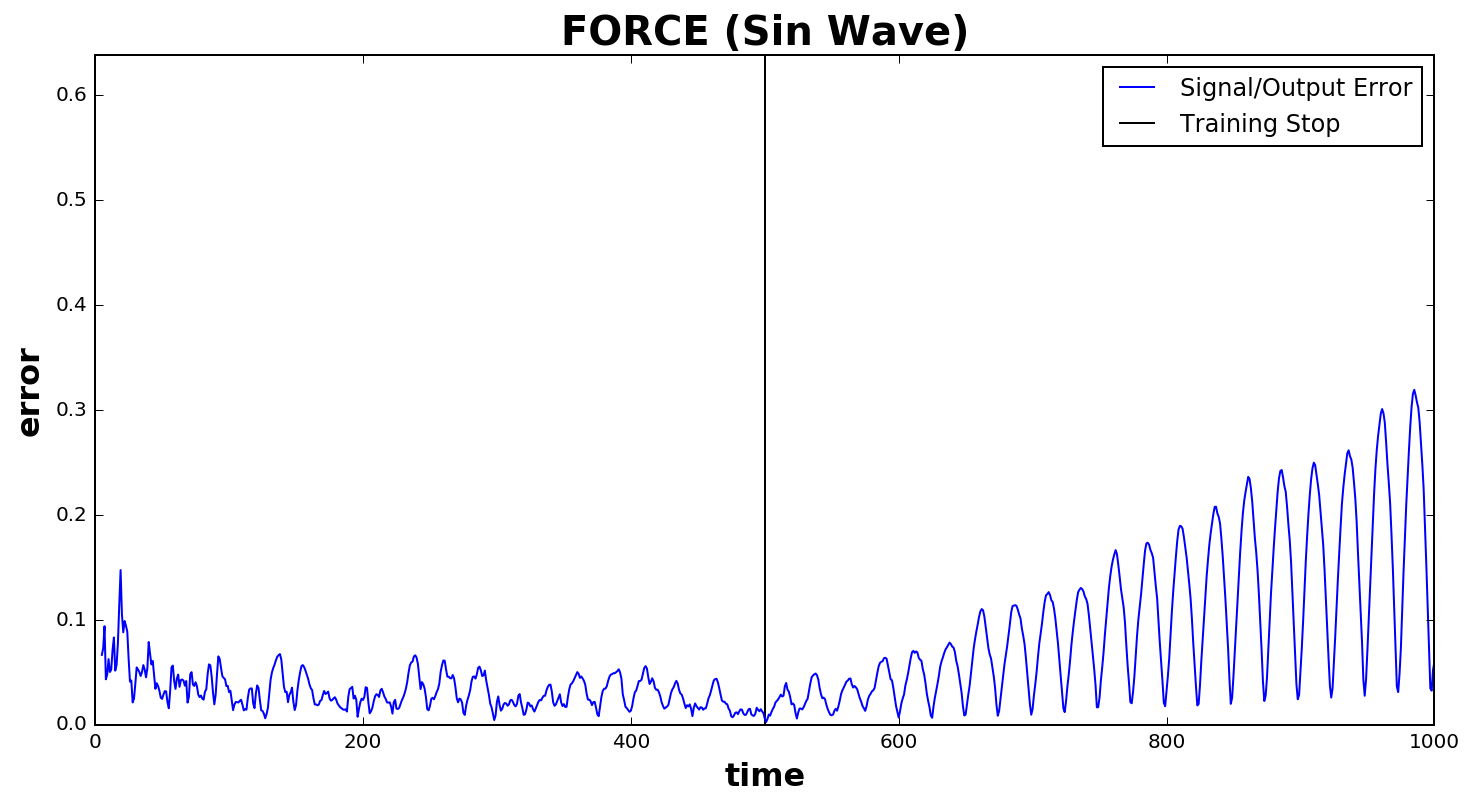

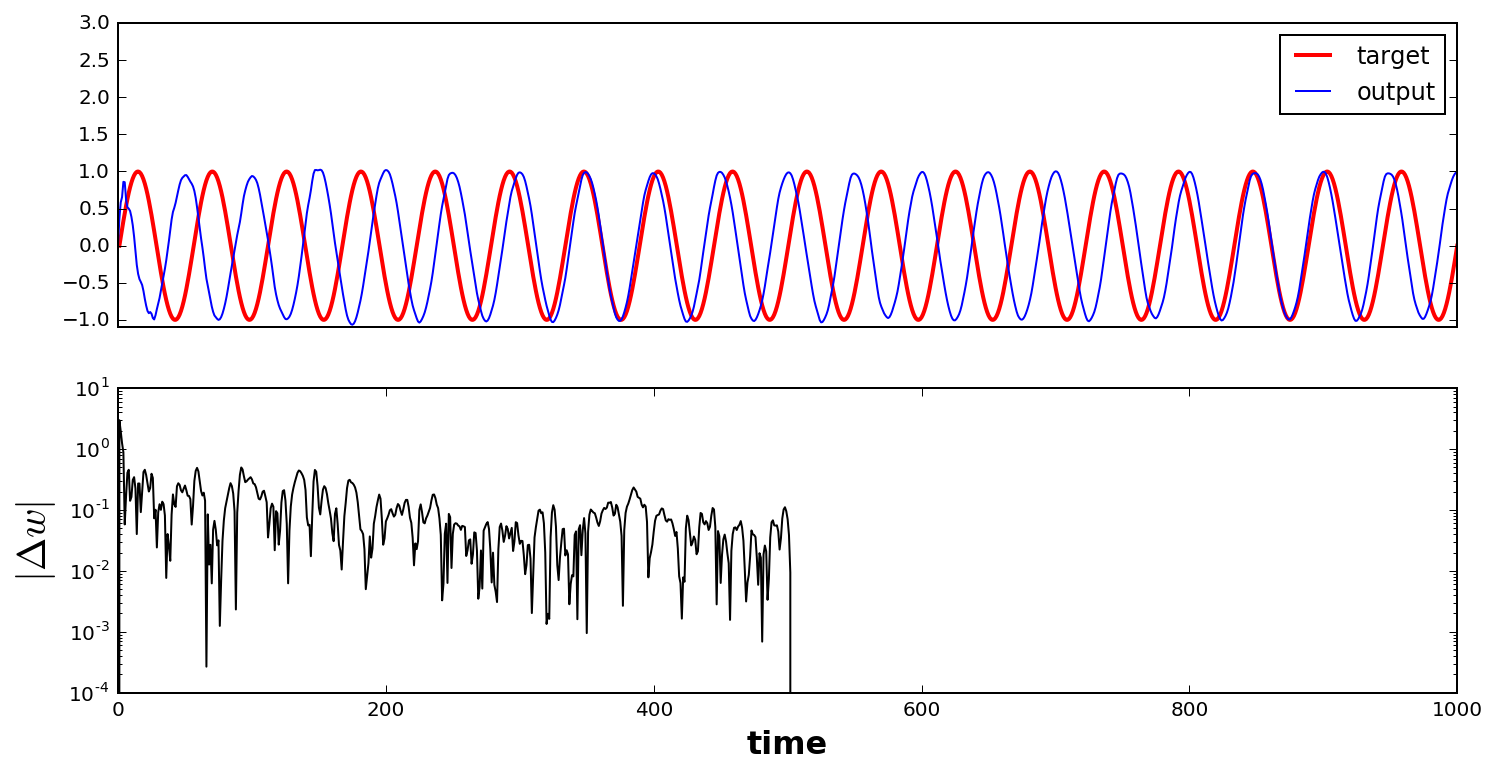

In [73]:
mean_signal_error(errors, t, tstop, title= "FORCE (Sin Wave)", burn_in=5)
error_signal_plot(t, z, wu, targets, offset=1)

In [74]:
# simulation parameters for DFORCE
lr = .4
rho = repeat(0.05, N)

In [75]:
derrors = []

for seed in seeds:
    J, _, wi, x0, u, w = set_simulation_parameters(seed, N, 1)
    
    def model(t0, x, tanh_x, _, inp, z): 
        return -x + g * dot(J, tanh_x) + dot(wi, z) * u
    
    x,t,z,_,_,_ = jedi.dforce(rho, target, model, lr, dt, tmax, tstop, x0, w)

    derror = np.abs(z-target(t))
    derrors.append(derror)
    
derrors = np.array(derrors)

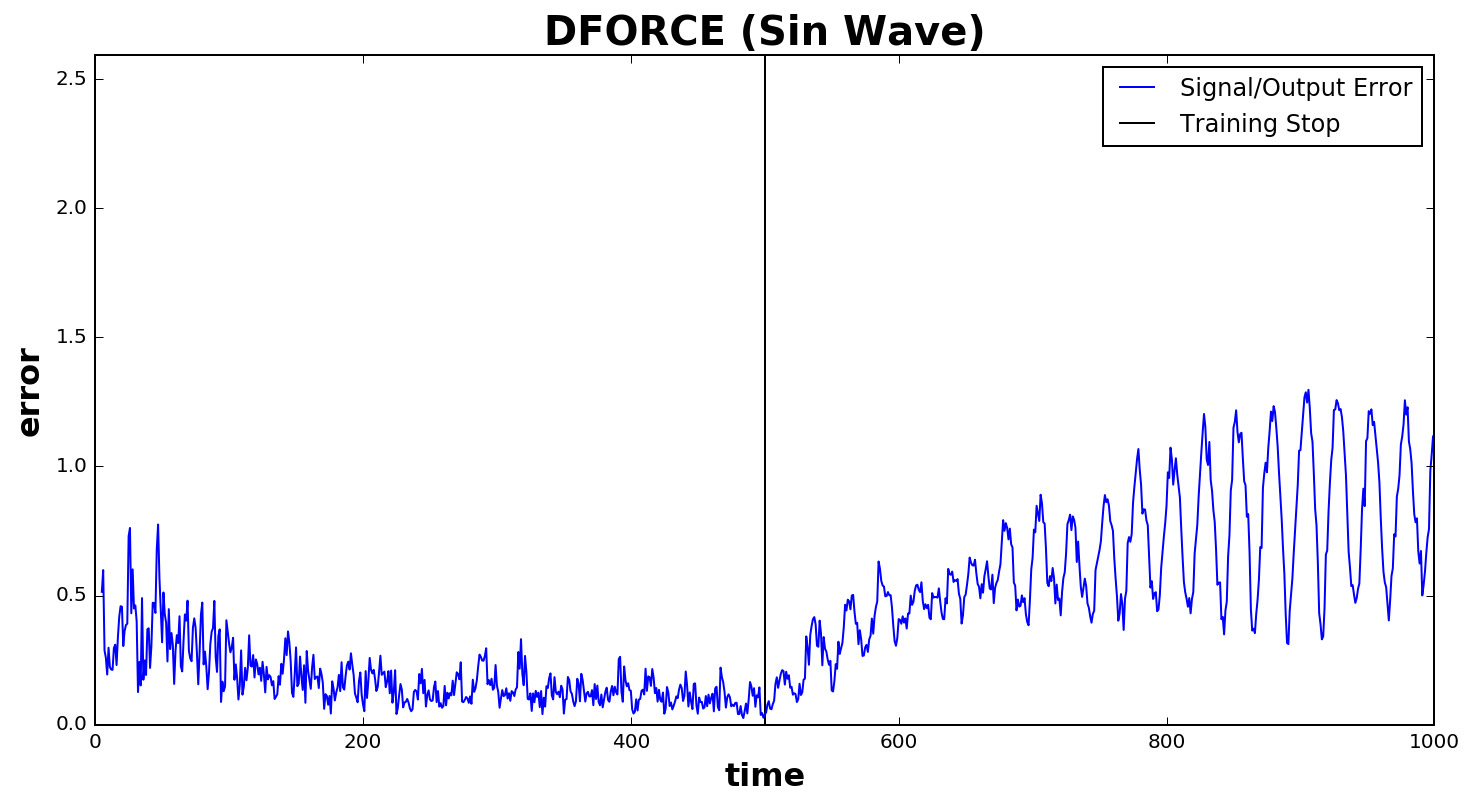

In [76]:
mean_signal_error(derrors, t, tstop, title="DFORCE (Sin Wave)", burn_in=5)

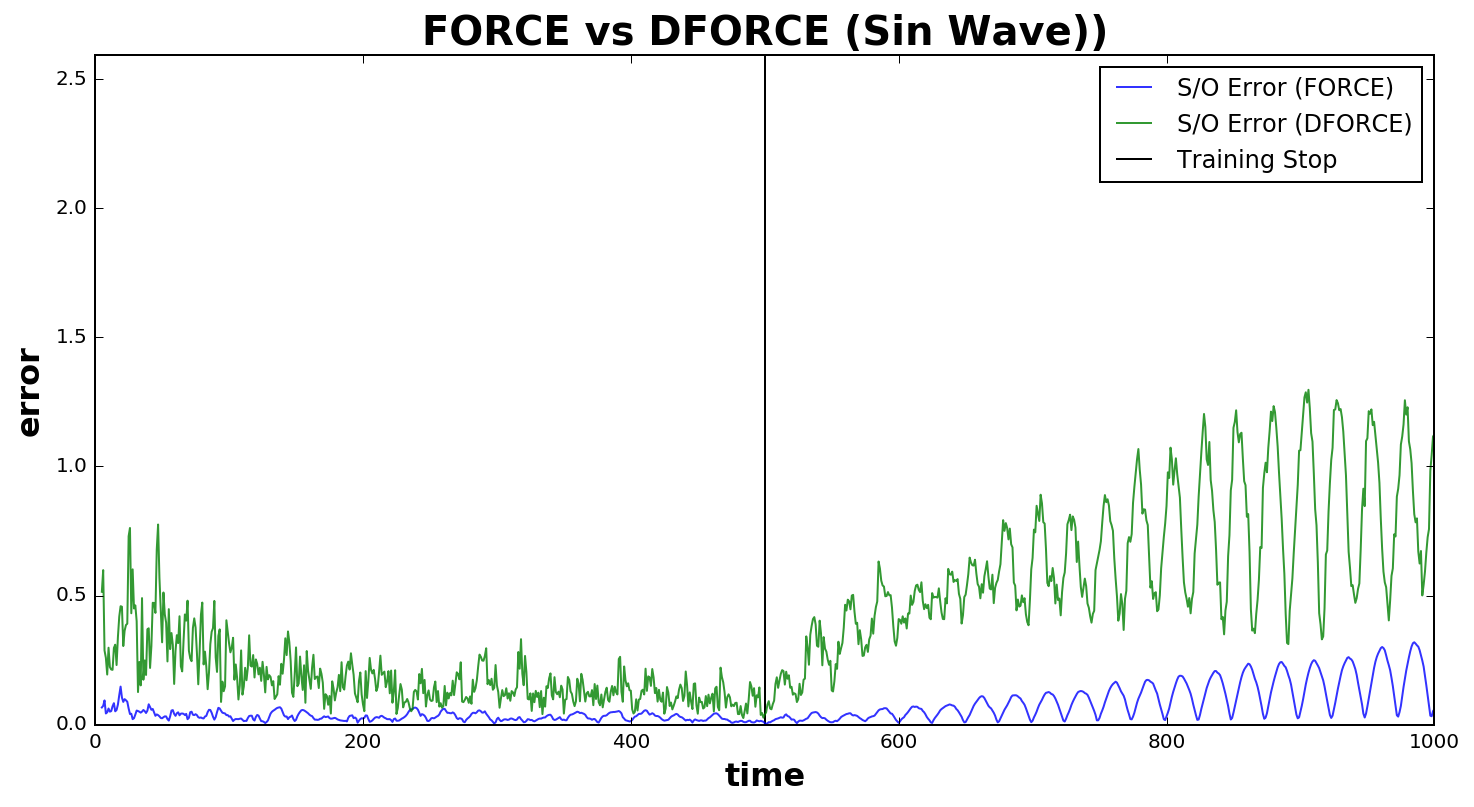

In [77]:
cross_mean_signal_error(errors, derrors, t, tstop, title="FORCE vs DFORCE (Sin Wave))", burn_in=5)

## 2) 1D Flip-Flop

In [ ]:
def gen_inp_targets():
    # Setting targets for flip-flop task
    targets= ones(tmax)
    targets[range(100,231)] = -1
    targets[range(300,351)] = -1
    targets[range(450,501)] = -1
    targets[range(650,751)] = -1
    targets[970:] = -1

    # Setting inputs for flip-flop task
    inputs = zeros(tmax)
    inputs[range(100,111)] = -1
    inputs[range(165,176)] = -1
    inputs[range(230,241)] = 1
    inputs[range(300,311)] = -1
    inputs[range(350,361)] = 1
    inputs[range(450,461)] = -1
    inputs[range(500,511)] = 1
    inputs[range(650,661)] = -1
    inputs[range(750,761)] = 1
    inputs[range(820,831)] = 1
    inputs[range(970,981)] = -1

    inputs = inputs.tolist()
    targets = targets.tolist()
    
    return inputs, targets

In [ ]:
# Plotting inputs and targets
inputs, targets = gen_inp_targets()
plt.figure(figsize=(12, 4))
plt.plot(range(tmax), targets, label="Target");
plt.plot(range(tmax), inputs, label="Input");
plt.ylim(-2,2);
plt.legend();

In [ ]:
dt = 1       # time step
tmax = 1000   # simulation length
tstop = 500  # learning stop time
g = 1.5      # gain factor?
N = 300     # size of stochastic pool
I = 1    # input size
lr = .8     # learning rat

In [ ]:
errors = []
wus = []
zs = []

for seed in seeds:
    J, Wi, wi, x0, u, w = set_simulation_parameters(seed, N, I)
    
    def model(t0, x, tanh_x, wi, inp, z):
        return -x + dot(J, tanh_x) + dot(Wi, inp) + dot(wi,z)
    
    x,t,z,_,wu,_ = jedi.force(targets, model, lr, dt, tmax, tstop, x0, w, inputs)
    
    zs.append(z)
    wus.append(wu)
    
    error = np.abs(z[1:]-np.array(targets))
    errors.append(error)
    
errors = np.array(errors)

In [ ]:
mean_signal_error(errors, t[1:], tstop, title= "FORCE (Flip-Flop)", burn_in=5)

In [ ]:
ind = 0

In [ ]:
print("Seed: %d" % ind)
mean_signal_error(errors[ind], t[1:], tstop, title= "FORCE (Flip-Flop)", burn_in=5, mean=False)
error_signal_plot(t, zs[ind], wus[ind], targets, offset=1)
ind+=1

In [ ]:
derrors = []
wus = []
zs = []

for seed in seeds:
    J, Wi, wi, x0, u, w = set_simulation_parameters(seed, N, 1)
    
    def model(t0, x, tanh_x, wi, inp, z):
        return -x + dot(J, tanh_x) + dot(Wi, inp) + dot(wi,z)
    
    x,t,z,_,wu,_ = jedi.dforce(rho, targets, model, lr, dt, tmax, tstop, x0, w, inputs)

    zs.append(z)
    wus.append(wu)
        
    derror = np.abs(z[1:]-np.array(targets))
    derrors.append(derror)
    
derrors = np.array(derrors)

In [ ]:
mean_signal_error(derrors, t[1:], tstop, title="DFORCE (Flip-Flop)", burn_in=5)

In [ ]:
# Setting seed index
ind = 0

In [ ]:
# Comparing performance across seeds
print("Seed: %d" % ind)
mean_signal_error(errors[ind], t[1:], tstop, title= "DFORCE", burn_in=5, mean=False)
error_signal_plot(t, zs[ind], wus[ind], targets, offset=1)
ind+=1

In [ ]:
# cross mean signal error
cross_mean_signal_error(errors, derrors, t[1:], tstop, title="FORCE vs DFORCE (Flip-Flop)", burn_in=5)

In [ ]:
# Setting seed index
ind = 0

In [ ]:
print("Seed: %d" % ind)
cross_mean_signal_error(errors[ind], derrors[ind], t[1:], tstop, title="FORCE vs DFORCE, (Flip-Flop)", 
                        burn_in=5, mean=False)
ind+=1

## 3) Lorentz Attractor

In [7]:
# Parameters specified by Abbott 2009.
def lorentz((x, y, z), t0, sigma=10., beta=8./3, rho=28.0):
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

In [8]:
T = 1500 # period
x0 = [1, 1, 1]  # starting vector
t_= np.linspace(0, 40, T)  # one thousand time steps
lorenz = odeint(lorentz, x0, t_)/10
targets = lorenz[500:,1]

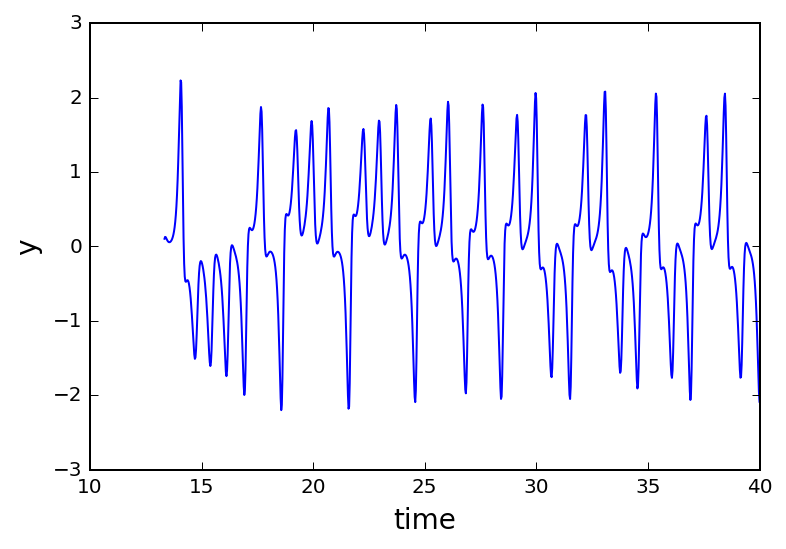

In [9]:
# Visualizing Lorentz attractor
plt.plot(t_[500:], targets);
plt.xlabel('time', fontsize=14);
plt.ylabel('y', fontsize=14);

In [48]:
dt = 1       # time step
tmax = 1000   # simulation length
tstop = 500  # learning stop time
g = 1.5      # gain factor?
N = 1000      # size of stochastic pool
lr = 1.0     # learning rate

In [49]:
errors = []
wus = []
zs = []

for seed in seeds:
    print("Seed: %d" % seed)
    
    J, _, wi, x0, u, w = set_simulation_parameters(seed, N, 1)
    
    # inp & z are dummy variables
    def model(t0, x, tanh_x, w, inp, z): 
        return -x + g * dot(J, tanh_x) + dot(w, tanh_x)
    
    x,t,z,_,wu,_ = jedi.force(targets, model, lr, dt, tmax, tstop, x0, w)

    zs.append(z)
    wus.append(wu)
        
    error = np.abs(z[1:]-np.array(targets))
    errors.append(error)

errors = np.array(errors)

Seed: 4504
Seed: 8623
Seed: 9839
Seed: 795
Seed: 1155


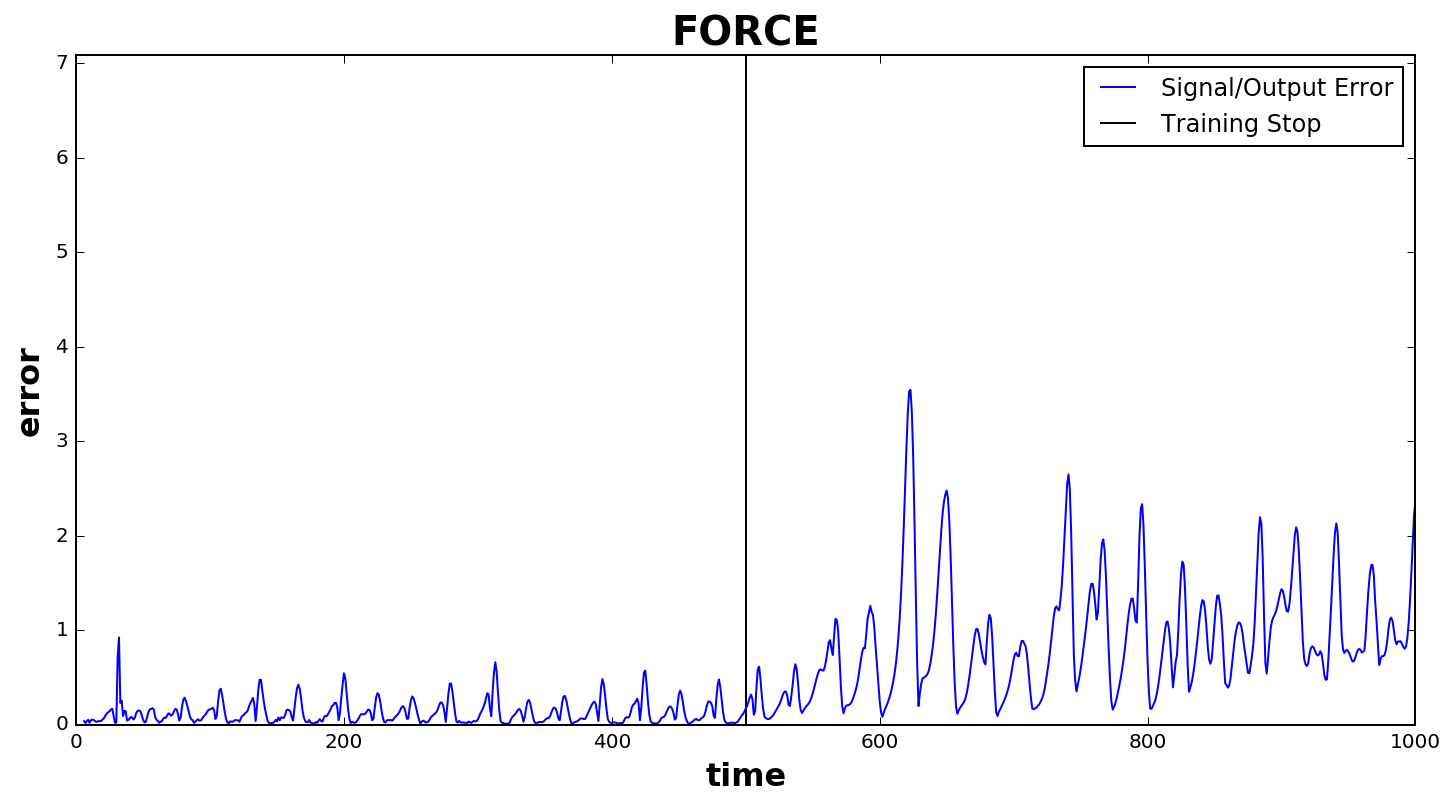

In [50]:
mean_signal_error(errors, t[1:], tstop, title= "FORCE", burn_in=5)

In [51]:
ind = 0  

Seed: 0


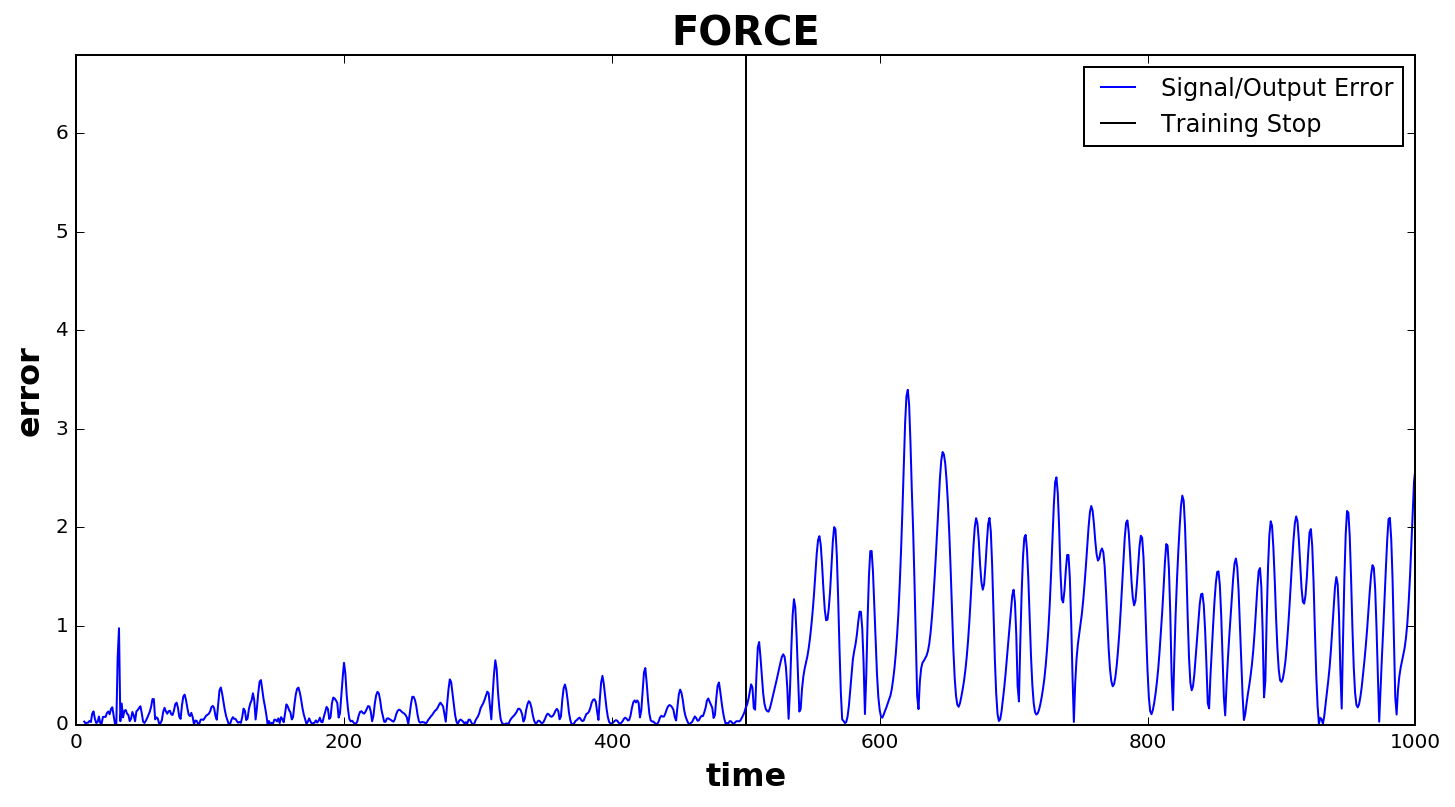

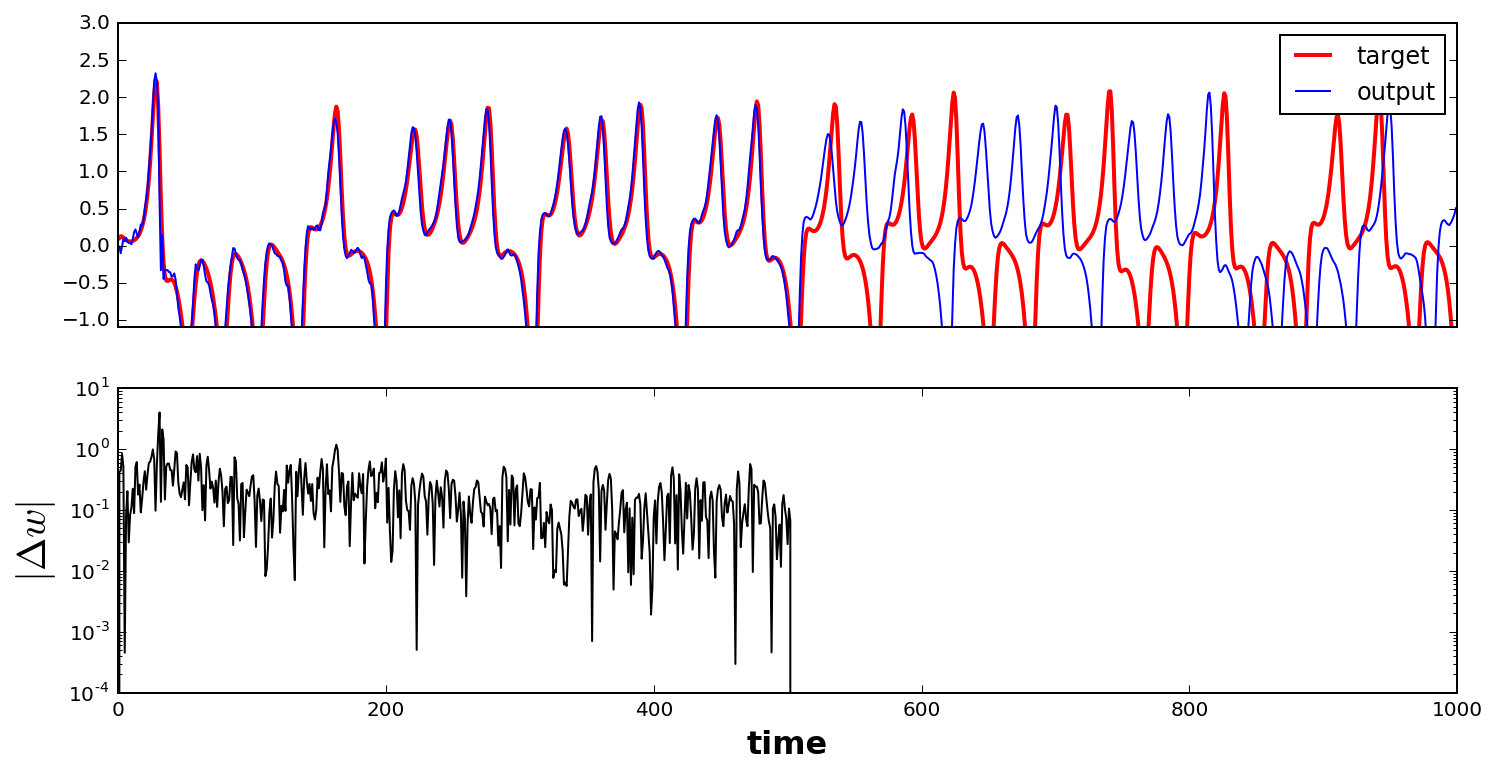

In [52]:
print("Seed: %d" % ind)
mean_signal_error(errors[ind], t[1:], tstop, title= "FORCE", burn_in=5, mean=False)
error_signal_plot(t, zs[ind], wus[ind], targets, offset=1)
ind+=1

In [15]:
# simulation parameters for DFORCE
rho = repeat(0.05, N)

In [16]:
dt = 1       # time step
tmax = 1000  # simulation length
tstop = 500  # learning stop time
g = 1.5      # gain factor?
N = 5000      # size of stochastic pool
lr = 0.6     # learning rate

In [45]:
derrors = []
wus = []
zs = []

seeder = [seeds[1]]

for seed in seeder:
    print("Seed: %d" % seed)
    J, _, _, x0, u, w = set_simulation_parameters(seed, N, 1)
    
    # inp & z are dummy variables
    def model(t0, x, tanh_x, w, inp, z): 
        return -x + g * dot(J, tanh_x) + dot(w, tanh_x) + dot(wi,z)
    
    x,t,z,_,wu,_ = jedi.dforce(rho, targets, model, lr, dt, tmax, tstop, x0, w)

    zs.append(z)
    wus.append(wu)
        
    derror = np.abs(z[1:]-np.array(targets))
    derrors.append(derror)
    
derrors = np.array(derrors)

Seed: 8623


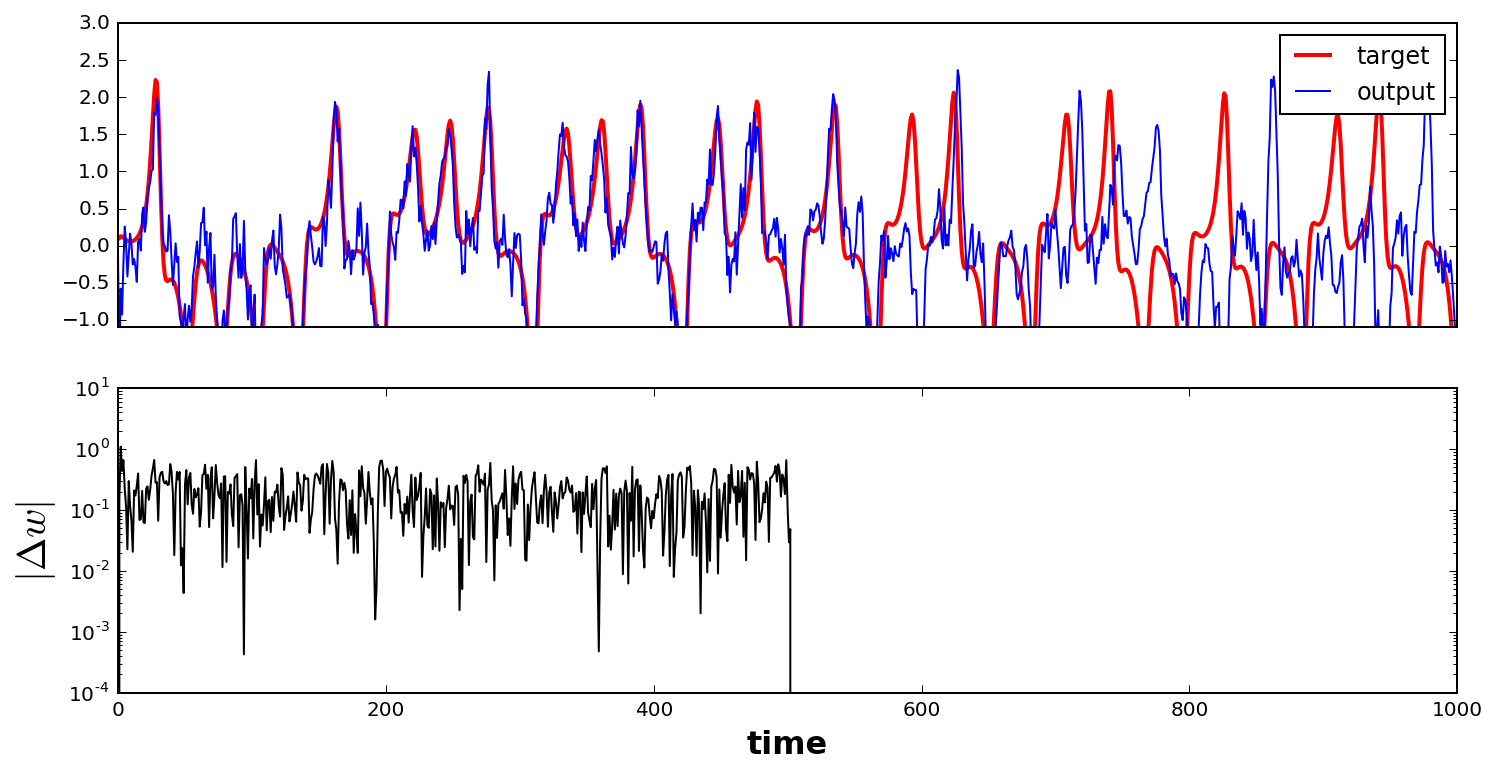

In [46]:
ind = 0 
error_signal_plot(t, zs[ind], wus[ind], targets, offset=1)

In [ ]:
mean_signal_error(derrors, t[1:], tstop, title= "DFORCE", burn_in=5)

Seed: 0


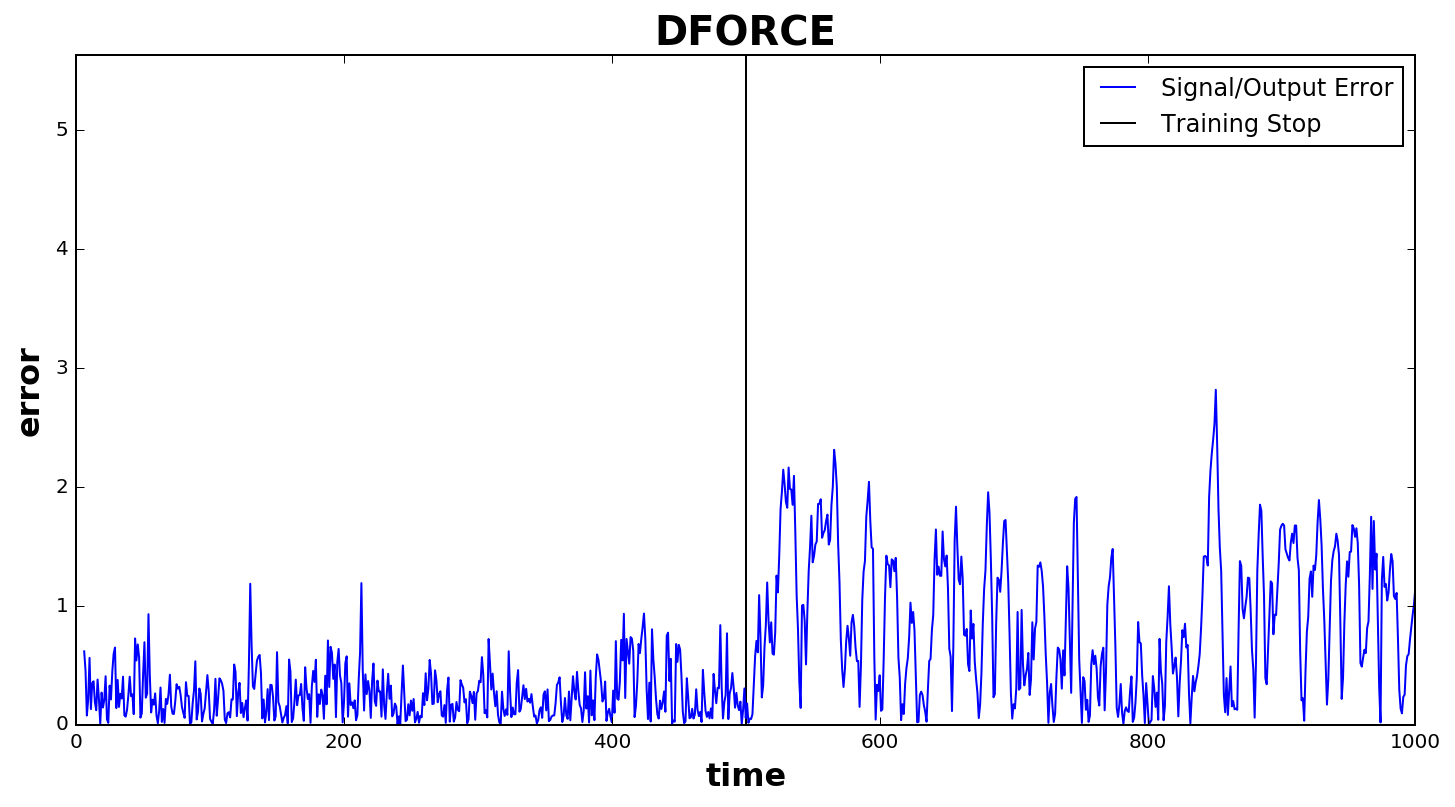

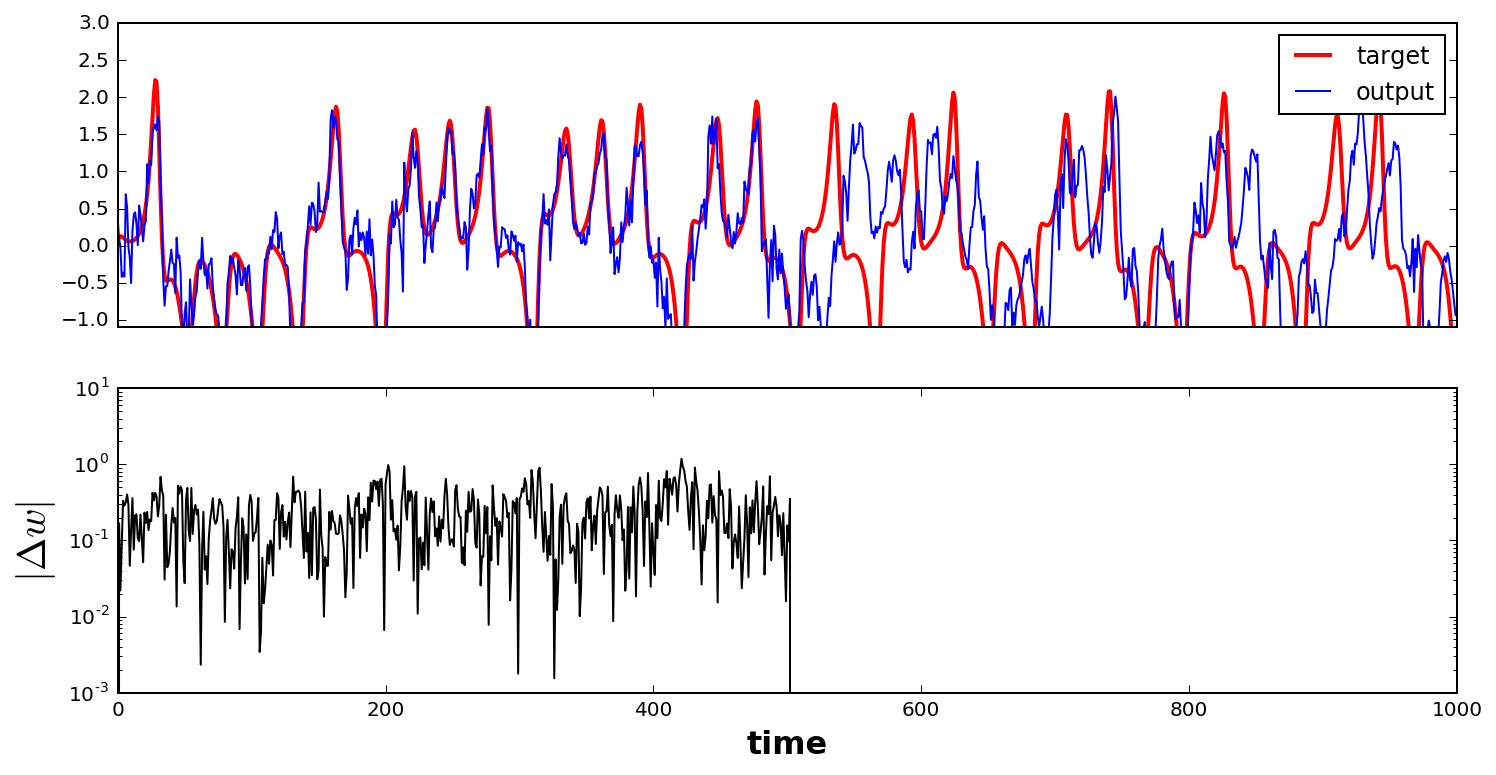

In [40]:
print("Seed: %d" % ind)
mean_signal_error(derrors[ind], t[1:], tstop, title= "DFORCE", burn_in=5, mean=False)
error_signal_plot(t, zs[ind], wus[ind], targets, offset=1)
ind+=1

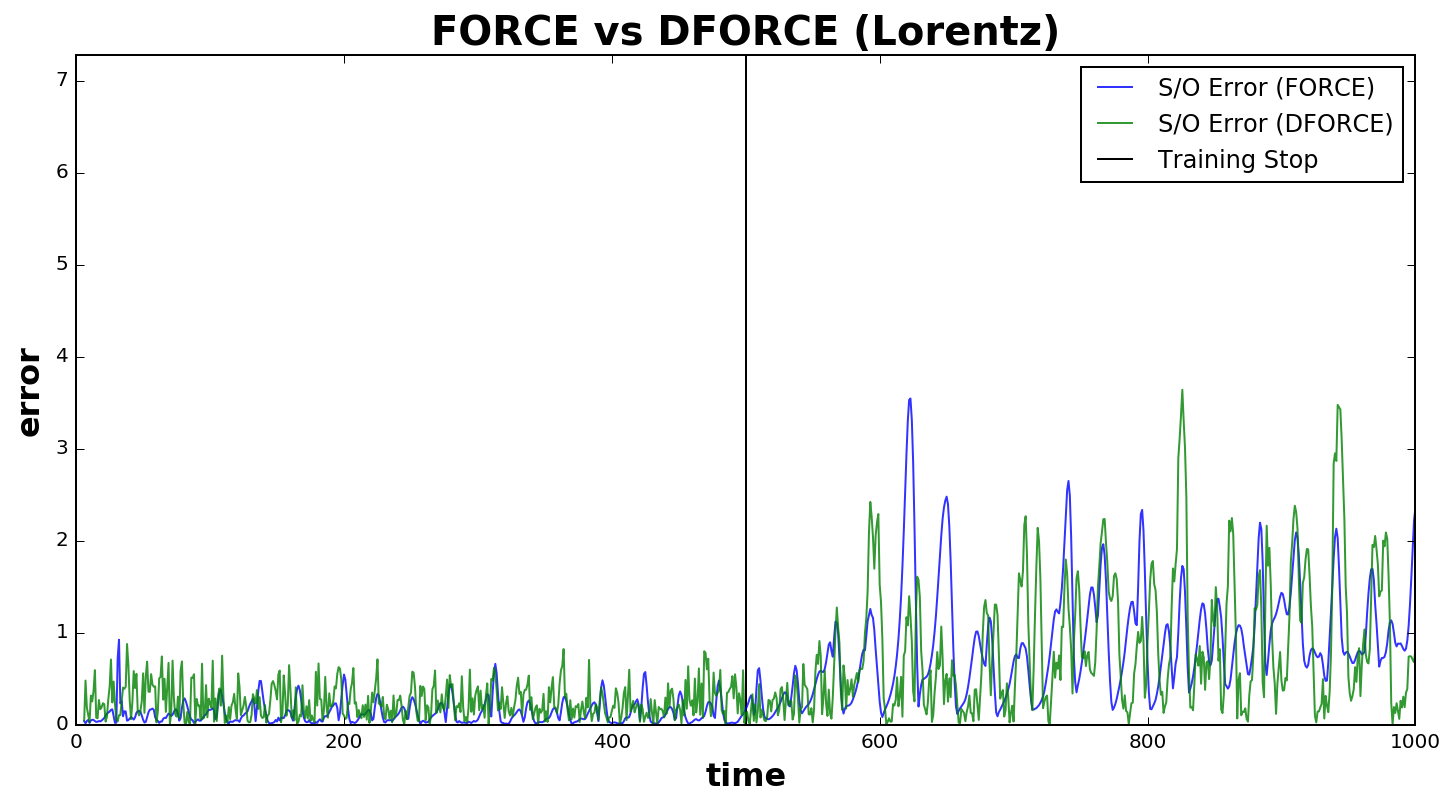

In [57]:
# cross mean signal error
cross_mean_signal_error(errors, derrors, t[1:], tstop, title="FORCE vs DFORCE (Lorentz)", burn_in=5)

## 4) Frequency Selector

In [71]:
T = 1000
t = np.linspace(0,1,T)

# t: time (seconds)
# eta: ordinal frequency (Hz)
fs = lambda eta, t: np.sin(eta*2*pi*t)

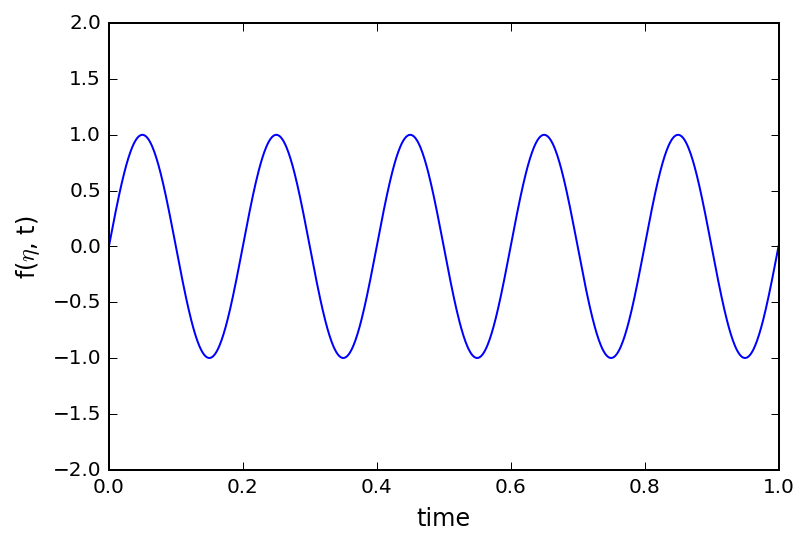

In [72]:
# Visualizing
eta = 5
plt.plot(t,fs(eta,t));
plt.xlabel("time", fontsize=12)
plt.ylabel("f($\eta$, t)", fontsize=12)
plt.ylim(-2,2);

In [73]:
# training batches

batches = []

for f in range(30):
    batches.append([fs(f,t), f*np.ones(T)/30])
    random.shuffle(batches)

In [74]:
batches[0][1].shape

(1000,)

In [164]:
dt = 1       # time step
tmax = 1000   # simulation length
tstop = 750  # learning stop time
g = 1.5      # gain factor?
N = 4000     # size of stochastic pool
I = 1    # input size
lr = 1   # learning rate

In [165]:
errors = []
wus = []
zs = []

J, Wi, wi, x0, u, w = set_simulation_parameters(seeds[1], N, I)

def model(t0, x, tanh_x, w, inp, z):
    return -x + dot(J, tanh_x) + dot(w, tanh_x)+ dot(Wi,inp)

i = int(np.random.uniform(0,26))

# Setting first input/target
target = batches[i][0]
inputs = batches[i][1]

x,t,z,w,wu,solver = jedi.force(target, model, lr, dt, tmax, tstop, x0, w, inputs)

zs.append(z)
wus.append(wu)

error = np.abs(z[1:]-np.array(target))
errors.append(error)

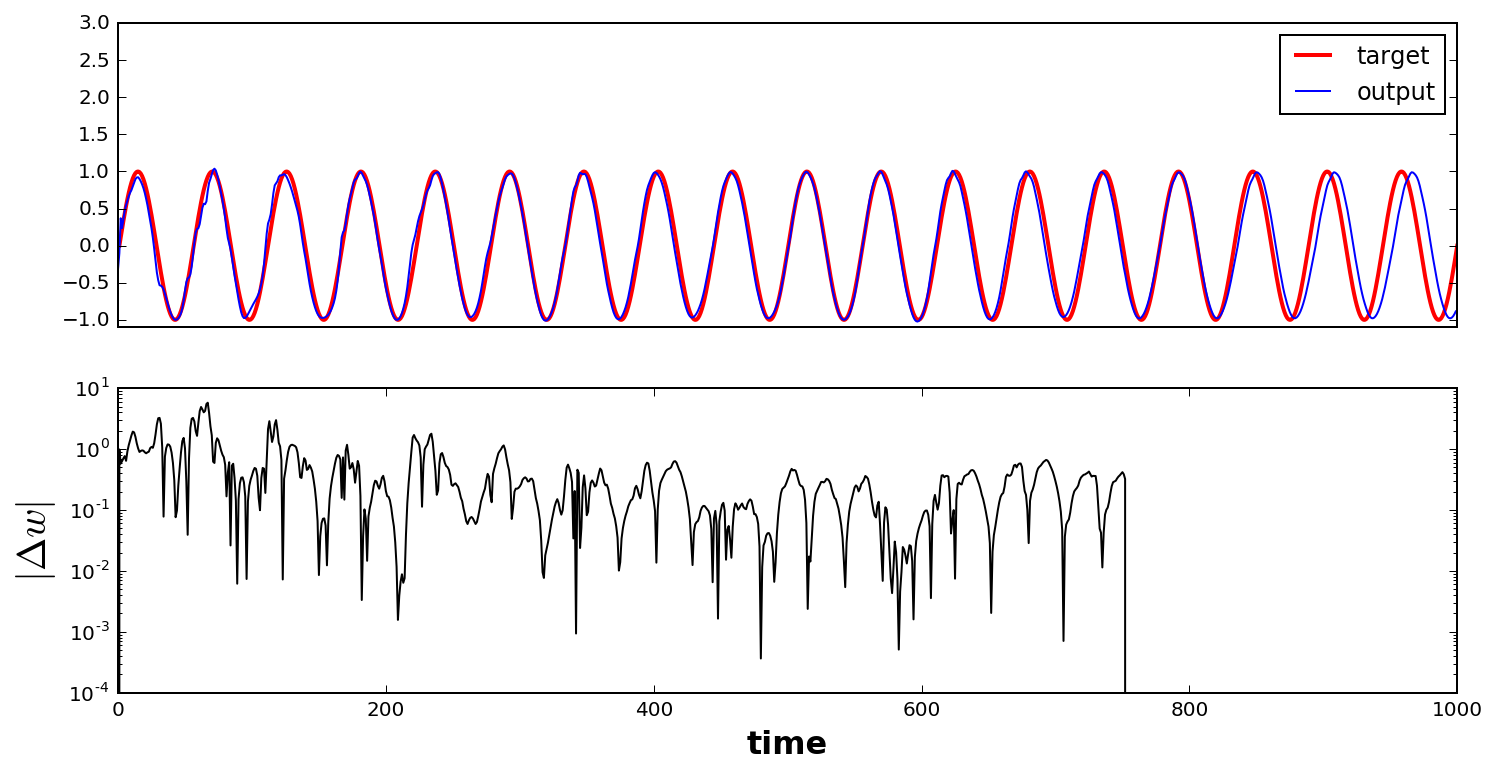

In [166]:
error_signal_plot(t, zs[0], wus[0], target, offset=1)

In [ ]:
for pattern in batches:
    targets = pattern[0]
    inputs = pattern[1]
    
    x,t,z,w,wu,solver = jedi.force(targets, model, 
                                   lr, dt, tmax, tstop, x[-1], w, 
                                   inputs)
    
    zs.append(z)
    wus.append(wu)
    
    error = np.abs(z[1:]-np.array(targets))
    errors.append(error)
    
errors = np.array(errors)

In [ ]:
ind=0

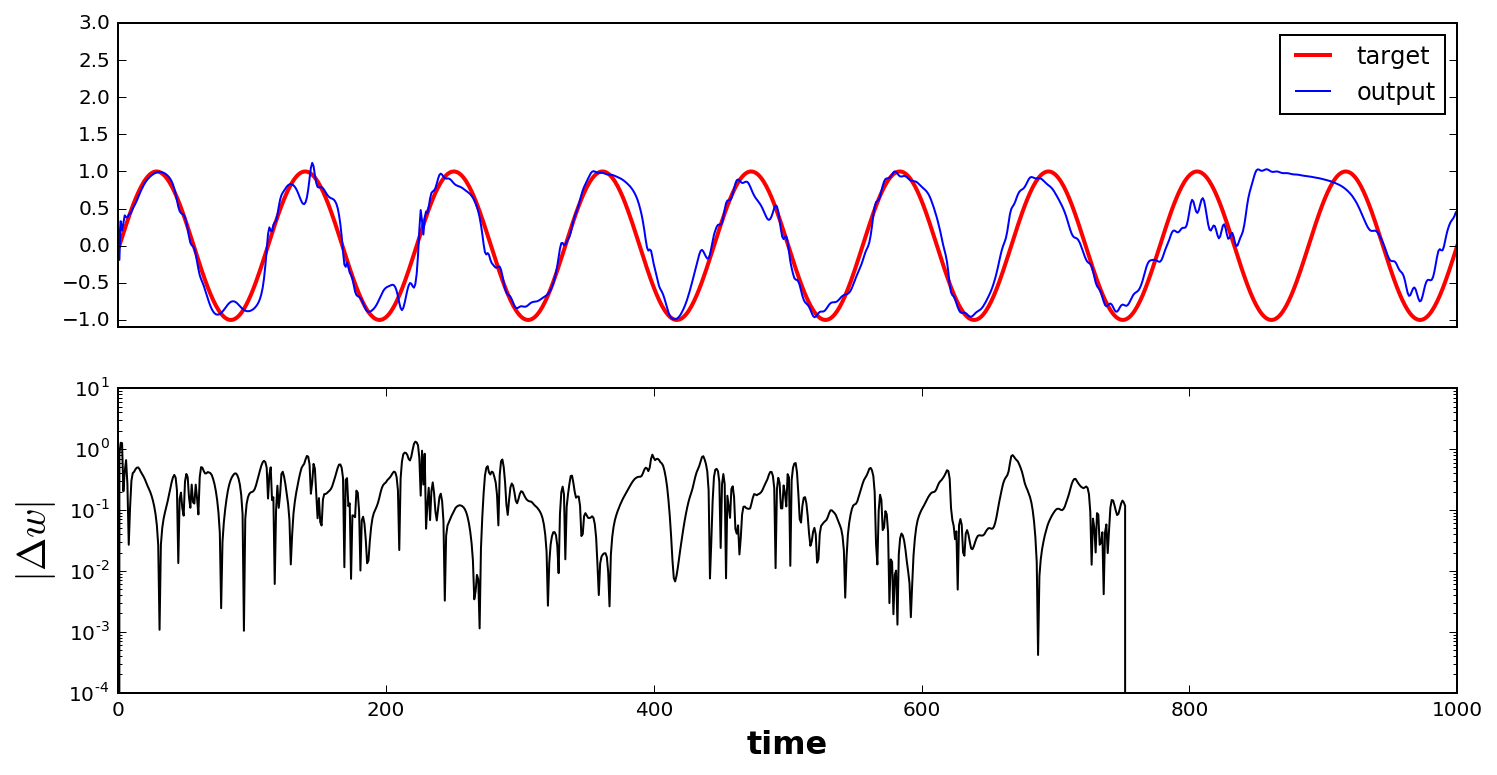

In [162]:
error_signal_plot(t, zs[ind+1], wus[ind+1], batches[ind][0], offset=1)
ind+=1

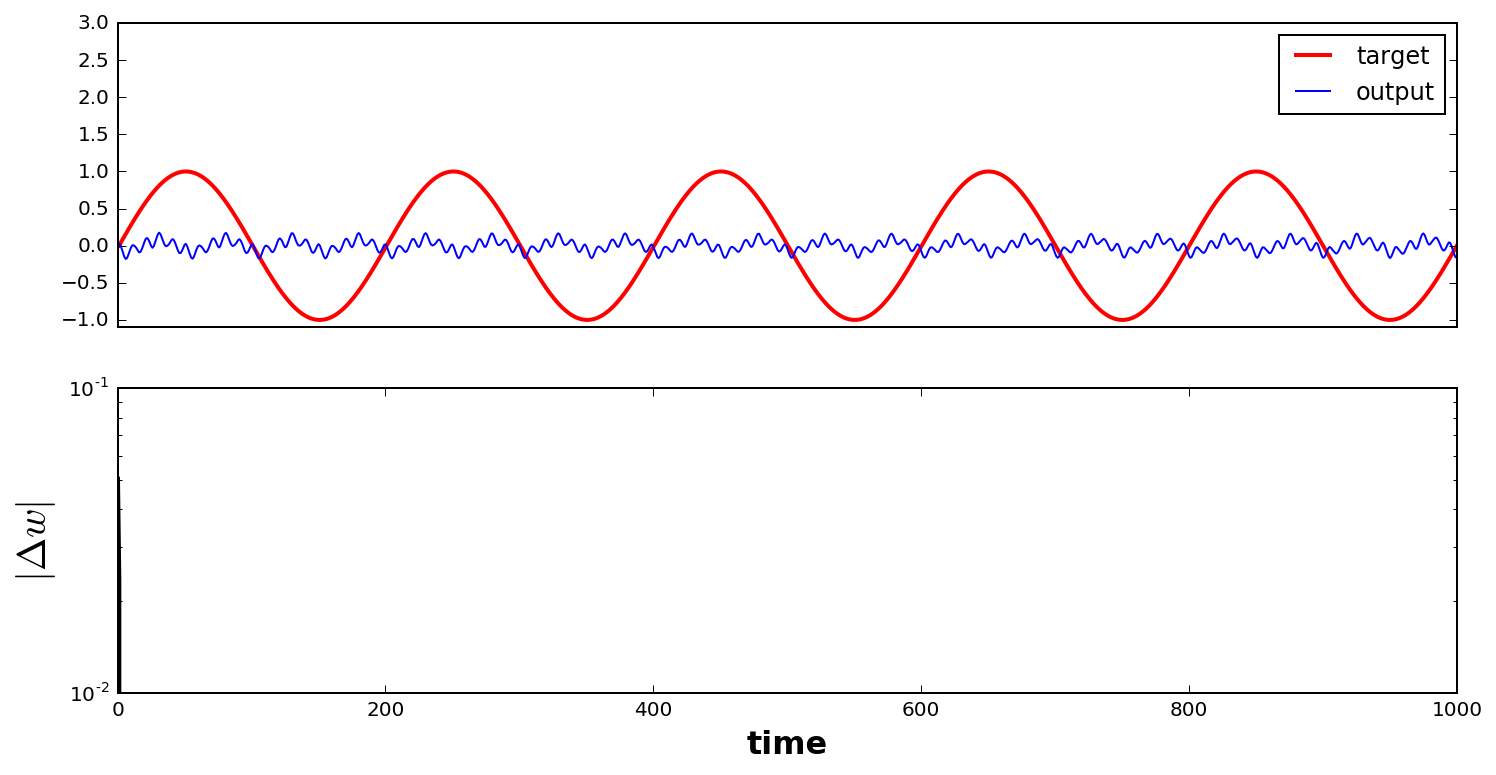

In [163]:
i = int(np.random.uniform(0,26))
targets = batches[i][0]
inputs = batches[i][1]

_,_,z,w,wu,_ = jedi.force(targets, model, lr, dt, tmax, 0, x[-1], w, inputs)
error_signal_plot(t, z, wu, targets, offset=1)